In [1]:
!pip install keras.utils
!pip install np_utils

## Necessary libraries

In [2]:
import sys
import numpy as np
from scipy.stats import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

import np_utils
import itertools
from keras.layers import LSTM


In [3]:
import tensorflow as tf
from keras.layers import Dropout

## Import the dataset

In [4]:
df = pd.read_csv("household_power_consumption.csv",
                 parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='DateTime')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Exploratory Data Analysis

In [5]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0
2008-12-13 21:37:00,0.422,0.078,242.56,1.8,0.0,0.0,0.0
2008-12-13 21:38:00,0.422,0.078,242.61,1.8,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1044506 non-null  float64
 1   Global_reactive_power  1044506 non-null  float64
 2   Voltage                1044506 non-null  float64
 3   Global_intensity       1044506 non-null  float64
 4   Sub_metering_1         1044506 non-null  float64
 5   Sub_metering_2         1044506 non-null  float64
 6   Sub_metering_3         1044506 non-null  float64
dtypes: float64(7)
memory usage: 64.0 MB


In [7]:
df.isnull().sum()

Global_active_power      4069
Global_reactive_power    4069
Voltage                  4069
Global_intensity         4069
Sub_metering_1           4069
Sub_metering_2           4069
Sub_metering_3           4069
dtype: int64

In [8]:
df.replace('?', np.nan, inplace=True)
df = df.dropna()

In [9]:
df.shape

(1044506, 7)

In [10]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [12]:
df.describe().round(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1044506.000,1044506.000,1044506.000,1044506.000,1044506.000,1044506.000,1044506.000
mean,1.108,0.118,239.960,4.718,1.177,1.475,5.934
std,1.130,0.110,3.285,4.764,6.321,6.353,8.210
min,0.076,0.000,223.490,0.200,0.000,0.000,0.000
25%,0.288,0.000,237.970,1.200,0.000,0.000,0.000
50%,0.550,0.098,240.210,2.400,0.000,0.000,0.000
75%,1.544,0.186,242.140,6.400,0.000,1.000,17.000
max,10.670,1.390,252.140,46.400,80.000,78.000,31.000


In [13]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.254841,-0.400987,0.999020,0.474129,0.456677,0.624107
Global_reactive_power,0.254841,1.000000,-0.120617,0.271843,0.137682,0.150528,0.076274
Voltage,-0.400987,-0.120617,1.000000,-0.411298,-0.203805,-0.178899,-0.284932
Global_intensity,0.999020,0.271843,-0.411298,1.000000,0.478198,0.462192,0.613220
Sub_metering_1,0.474129,0.137682,-0.203805,0.478198,1.000000,0.060830,0.115600
Sub_metering_2,0.456677,0.150528,-0.178899,0.462192,0.060830,1.000000,0.106461
Sub_metering_3,0.624107,0.076274,-0.284932,0.613220,0.115600,0.106461,1.000000


In [14]:
df.index = pd.to_datetime(df.index)

## Visualizing Data

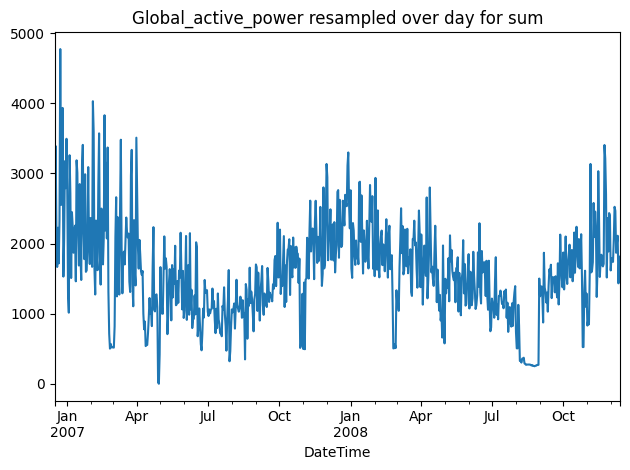

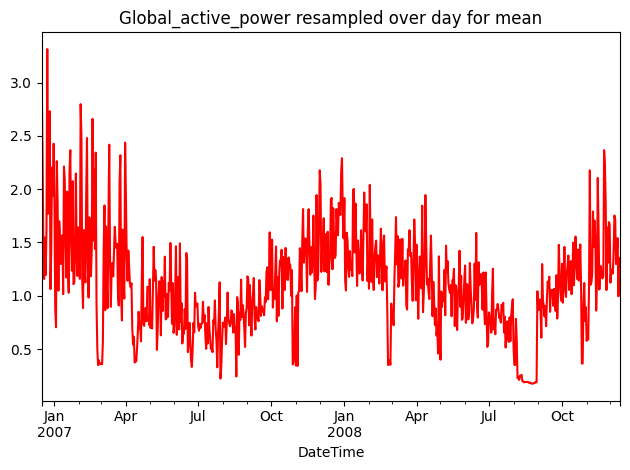

In [15]:
import matplotlib.pyplot as plt
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
plt.tight_layout()
plt.show()

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red')
plt.tight_layout()
plt.show()

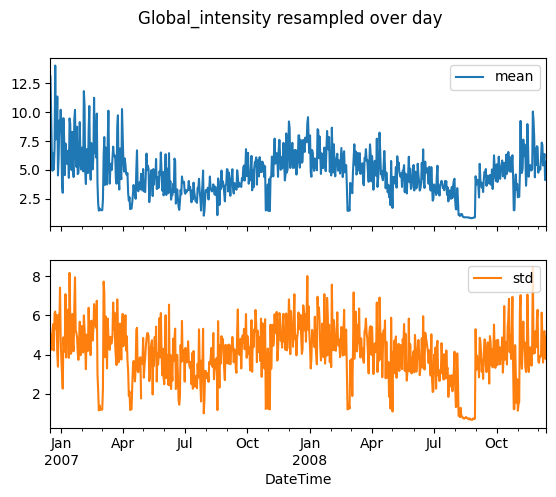

In [16]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

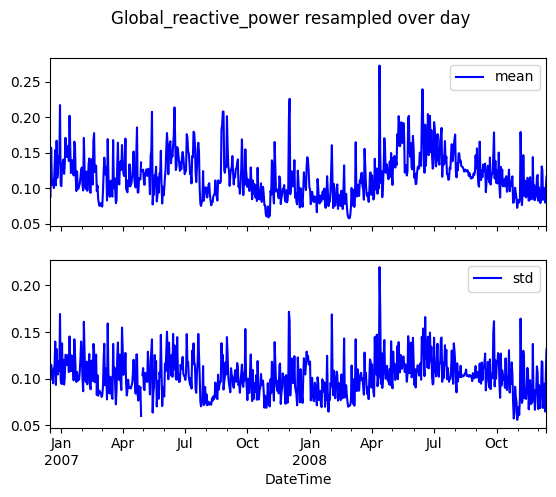

In [17]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='blue')
plt.show()

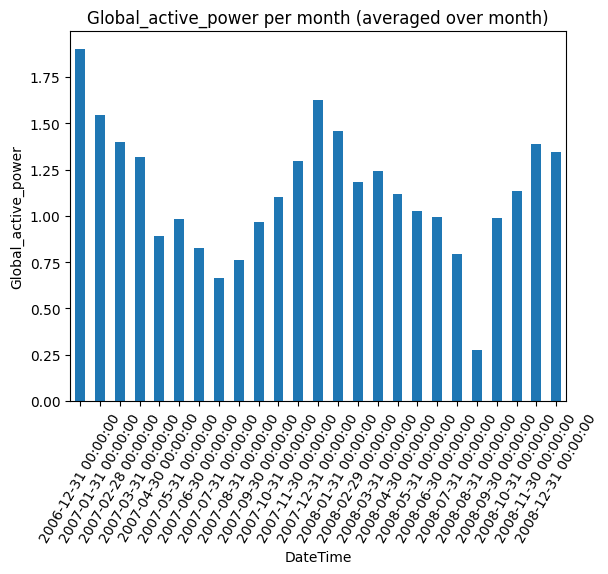

In [18]:
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

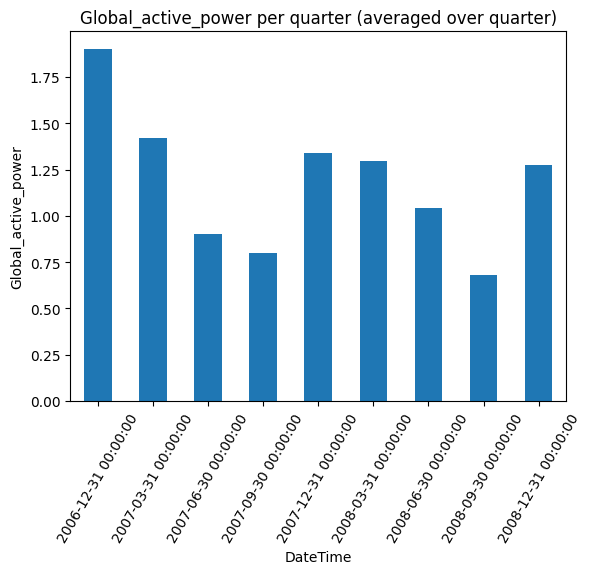

In [19]:
## Mean of 'Global_active_power' resampled over quarter
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

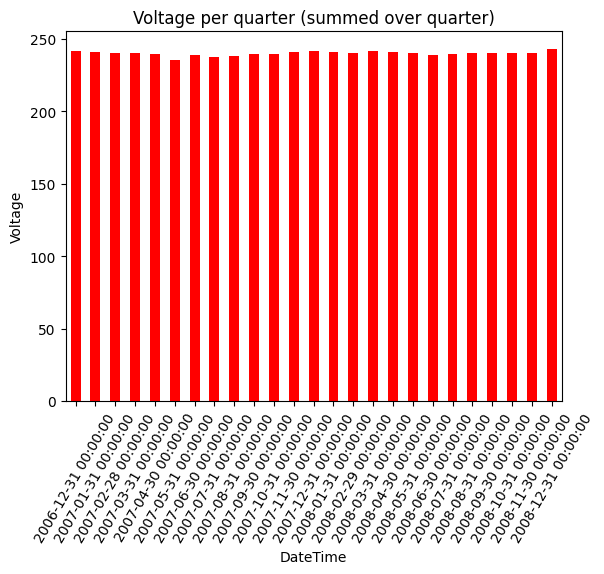

In [20]:
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

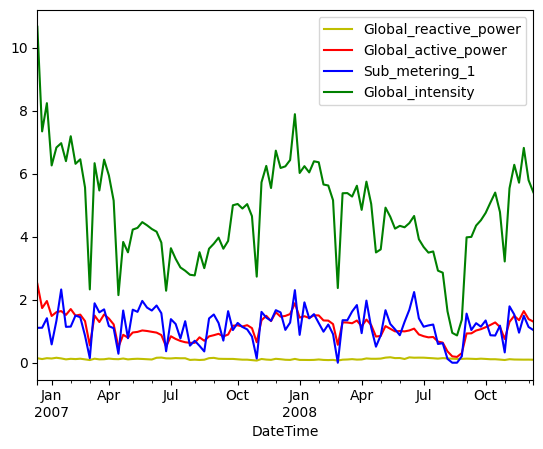

In [21]:
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

In [22]:
X = df.iloc[:,[1,3,4,5,6]]
y = df.iloc[:,0]

In [23]:
X.head()

,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,
2006-12-16 17:24:00,0.418,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,0.436,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,0.498,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,0.502,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,0.528,15.8,0.0,1.0,17.0


In [24]:
y.head()

DateTime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

## Building the Linear Regression Model

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions

array([1.59615534, 0.40944764, 0.74169811, ..., 0.33976671, 0.58072056,
       1.53538397])

In [27]:
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))
print('RSquarevalue:',metrics.r2_score(y_test,predictions))

MAE: 0.028170099331255458
MSE: 0.0019173565440855542
RMSE: 0.043787630035040194
RSquarevalue: 0.9984985672474445


In [28]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [29]:
df_resample = df.resample('h').mean()
df_resample.shape

(17477, 7)

In [30]:
values = df_resample.values
values.round(3)

array([[4.22300e+00, 2.29000e-01, 2.34644e+02, ..., 0.00000e+00,
        5.28000e-01, 1.68610e+01],
       [3.63200e+00, 8.00000e-02, 2.34580e+02, ..., 0.00000e+00,
        6.71700e+00, 1.68670e+01],
       [3.40000e+00, 8.50000e-02, 2.33233e+02, ..., 0.00000e+00,
        1.43300e+00, 1.66830e+01],
       ...,
       [2.25800e+00, 1.54000e-01, 2.38791e+02, ..., 0.00000e+00,
        5.50000e-01, 5.93300e+00],
       [1.47300e+00, 8.70000e-02, 2.41108e+02, ..., 0.00000e+00,
        0.00000e+00, 1.04830e+01],
       [3.67000e-01, 5.50000e-02, 2.41816e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [32]:
values = values.astype('float32')

In [33]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0


In [34]:
df_resample

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.000000,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.000000,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.000000,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.000000,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.000000,0.416667,17.216667
...,...,...,...,...,...,...,...
2008-12-13 17:00:00,2.755267,0.080133,237.909167,11.676667,9.283333,0.033333,10.983333
2008-12-13 18:00:00,1.329000,0.068333,238.466167,5.620000,0.000000,0.000000,0.000000
2008-12-13 19:00:00,2.258433,0.154367,238.791500,9.503333,0.000000,0.550000,5.933333


## Scale Transform

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

In [36]:
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 7) (8760,) (1035745, 1, 7) (1035745,)


## LSTM Model (Approach 2)

In [37]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
126/126 - 38s - loss: 0.0115 - val_loss: 0.0028 - 38s/epoch - 298ms/step
Epoch 2/20
126/126 - 32s - loss: 0.0035 - val_loss: 0.0016 - 32s/epoch - 254ms/step
Epoch 3/20
126/126 - 33s - loss: 0.0025 - val_loss: 0.0013 - 33s/epoch - 264ms/step
Epoch 4/20
126/126 - 37s - loss: 0.0022 - val_loss: 0.0011 - 37s/epoch - 296ms/step
Epoch 5/20
126/126 - 32s - loss: 0.0020 - val_loss: 0.0011 - 32s/epoch - 256ms/step
Epoch 6/20
126/126 - 32s - loss: 0.0018 - val_loss: 0.0010 - 32s/epoch - 256ms/step
Epoch 7/20
126/126 - 34s - loss: 0.0018 - val_loss: 0.0010 - 34s/epoch - 266ms/step
Epoch 8/20
126/126 - 56s - loss: 0.0017 - val_loss: 9.9913e-04 - 56s/epoch - 442ms/step
Epoch 9/20
126/126 - 60s - loss: 0.0017 - val_loss: 9.7607e-04 - 60s/epoch - 476ms/step
Epoch 10/20
126/126 - 62s - loss: 0.0017 - val_loss: 9.7608e-04 - 62s/epoch - 492ms/step
Epoch 11/20
126/126 - 61s - loss: 0.0017 - val_loss: 9.6685e-04 - 61s/epoch - 484ms/step
Epoch 12/20
126/126 - 61s - loss: 0.0016 - val_loss: 9.672

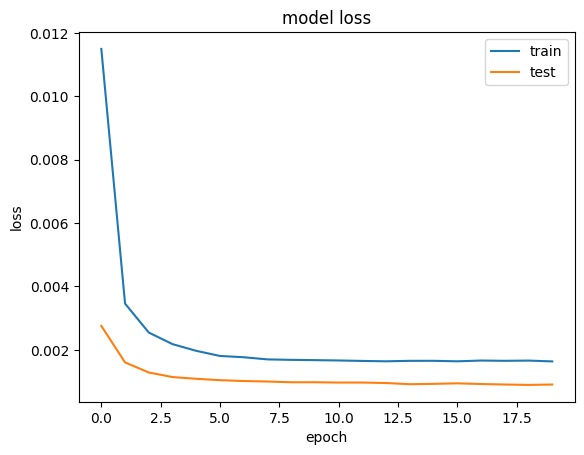

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [40]:
predictions = model.predict(test_X)

32368/32368 [==============================] - 69s 2ms/step


In [41]:
from sklearn import metrics
print('MAE:',metrics.mean_absolute_error(test_y,predictions))
print('MSE:',metrics.mean_squared_error(test_y, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y,predictions)))
print('RSquarevalue:',metrics.r2_score(test_y,predictions))

MAE: 0.019037992
MSE: 0.00090471795
RMSE: 0.03007853
RSquarevalue: 0.9201377389690141


In [44]:
predictions

array([[0.40745863],
       [0.40641463],
       [0.39870602],
       ...,
       [0.04501315],
       [0.04555752],
       [0.04417026]], dtype=float32)

In [47]:
train_y

array([0.4987729 , 0.50009435, 0.50141585, ..., 0.42325845, 0.4255239 ,
       0.42571267], dtype=float32)

C:\Users\Suresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


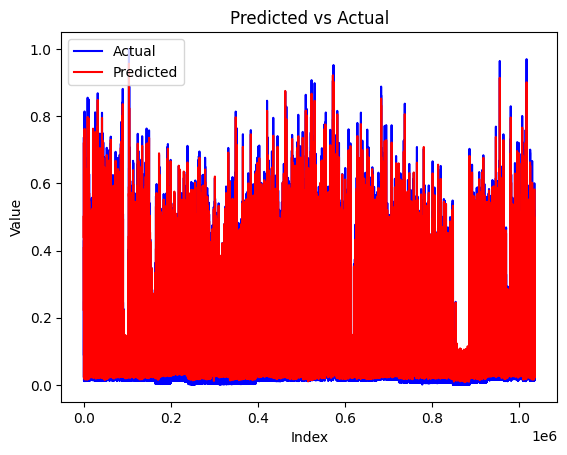

In [53]:
import matplotlib.pyplot as plt

# Assuming you have the actual values in a list or array called 'actual'
# and the predicted values in a list or array called 'predicted'

# Plotting the actual values
plt.plot(test_y, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(predictions, label='Predicted',color = 'red')

# Adding labels and title to the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


## Exponential Smoothing

In [54]:
import matplotlib.pyplot as plt
import numpy as np
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# apply exponential smoothing
smoothed = []
alpha = 0.7
for i in range(len(scaled)):
  if i == 0:
    smoothed.append(scaled[0])
  else:
    smoothed.append(alpha * scaled[i] + (1 - alpha) * smoothed[i-1]) # alpha = smoothing factor, scaled[i] = smoothed statistic, scaled[i-i] = previous statistic
# invert the scaling
unscaled_smoothed = []
for i in range(len(smoothed)):
  unscaled_smoothed.append(scaler.inverse_transform(np.array(smoothed[i]).reshape(1, -1))[0])


In [84]:
smoothed

[array([0.39078724, 0.30071944, 0.39616013, 0.39393938, 0.        ,
        0.01282051, 0.54838705], dtype=float32),
 array([0.4663772 , 0.30978417, 0.3665967 , 0.46363637, 0.        ,
        0.01282051, 0.5258064 ], dtype=float32),
 array([0.4899792 , 0.34372663, 0.3494204 , 0.48454547, 0.        ,
        0.02179487, 0.54161286], dtype=float32),
 array([0.4979849 , 0.35592374, 0.35526243, 0.4908182 , 0.        ,
        0.01551282, 0.5463548 ], dtype=float32),
 array([0.3866052 , 0.37267643, 0.404414  , 0.38360912, 0.        ,
        0.01362821, 0.54777735], dtype=float32),
 array([0.3435443 , 0.37468064, 0.40303427, 0.33932516, 0.        ,
        0.02203718, 0.5482041 ], dtype=float32),
 array([0.34265172, 0.3742747 , 0.40433064, 0.33816117, 0.        ,
        0.01558551, 0.54833215], dtype=float32),
 array([0.34225184, 0.37415293, 0.4078959 , 0.337812  , 0.        ,
        0.01365001, 0.5483706 ], dtype=float32),
 array([0.34001744, 0.36908042, 0.37891337, 0.33770725, 0.      

In [85]:
from sklearn.model_selection import train_test_split
train_size = int(len(smoothed) * 0.8)
train_data, test_data = smoothed[:train_size], smoothed[train_size:]

train_data = np.array(train_data)
test_data = np.array(test_data)

# Define the input and output data for training
X_train = train_data[:-1]  # Input data (all but the last)
y_train = train_data[1:]   # Output data (all but the first)

# Reshape the data for LSTM input: (samples, time steps, features)
X_train = X_train.reshape(-1, 1, 1)
y_train = y_train.reshape(-1, 1)

# Define the input data for testing
X_test = test_data[:-1]  # Input data (all but the last)

# Reshape the data for LSTM input: (samples, time steps, features)
X_test = X_test.reshape(-1, 1, 1)

# Define the expected output for testing
y_test = test_data[1:]  # Output data (all but the first)

In [86]:
y_test

array([[1.6814744e-02, 8.2750075e-02, 5.6234086e-01, ..., 0.0000000e+00,
        1.0460161e-09, 2.5295891e-02],
       [1.6673649e-02, 8.3242290e-02, 5.5767244e-01, ..., 0.0000000e+00,
        3.1380482e-10, 3.0169412e-02],
       [1.6367018e-02, 8.3389953e-02, 5.5724925e-01, ..., 0.0000000e+00,
        9.4141452e-11, 9.0508237e-03],
       ...,
       [3.2721400e-02, 5.4578006e-02, 6.3931000e-01, ..., 0.0000000e+00,
        0.0000000e+00, 3.9124188e-33],
       [3.2678414e-02, 5.5653978e-02, 6.5772623e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.1737257e-33],
       [3.2665521e-02, 5.5976771e-02, 6.6447276e-01, ..., 0.0000000e+00,
        0.0000000e+00, 3.5211773e-34]], dtype=float32)

In [92]:
from keras.optimizers import Adam
model2 = Sequential()
model2.add(LSTM(8, input_shape=(1, 1)))
model2.add(Dropout(0.2))
model2.add(Dense(1))
optimizer = tf.keras.optimizers.Adam()
model2.compile(loss='mean_squared_error', optimizer=optimizer)

In [93]:
history = model2.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1)

Epoch 1/10
22849/22849 [==============================] - 68s 3ms/step - loss: 0.0031
Epoch 2/10
22849/22849 [==============================] - 76s 3ms/step - loss: 0.0020
Epoch 3/10
22849/22849 [==============================] - 69s 3ms/step - loss: 0.0020
Epoch 4/10
22849/22849 [==============================] - 69s 3ms/step - loss: 0.0020
Epoch 5/10
22849/22849 [==============================] - 60s 3ms/step - loss: 0.0020
Epoch 6/10
22849/22849 [==============================] - 65s 3ms/step - loss: 0.0020
Epoch 7/10
22849/22849 [==============================] - 68s 3ms/step - loss: 0.0020
Epoch 8/10
22849/22849 [==============================] - 62s 3ms/step - loss: 0.0020
Epoch 9/10
22849/22849 [==============================] - 73s 3ms/step - loss: 0.0020
Epoch 10/10
22849/22849 [==============================] - 85s 4ms/step - loss: 0.0020


In [140]:
pred2 = model2.predict(X_test)


45698/45698 [==============================] - 72s 2ms/step


In [118]:
pred2

array([[0.02572845],
       [0.08589648],
       [0.5494561 ],
       ...,
       [0.01013885],
       [0.01013885],
       [0.01013885]], dtype=float32)

In [120]:
print("Length of y_test:", len(y_test))
print("Length of predictions:", len(pred2))
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", pred2.shape)


Length of y_test: 208901
Length of predictions: 1462307
Shape of y_test: (208901, 7)
Shape of predictions: (1462307, 1)


In [121]:
predictions2 = pred2[:len(y_test)]

In [122]:
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions2.shape)


Shape of y_test: (208901, 7)
Shape of predictions: (208901, 1)


In [123]:
# Flatten y_test to match the shape of predictions
y_test_flat = y_test.flatten()

# Ensure predictions and y_test_flat have the same length
num_predictions = min(len(predictions2), len(y_test_flat))
y_test_flat = y_test_flat[:num_predictions]
predictions2 = predictions2[:num_predictions]

# Evaluate the model
mae = metrics.mean_absolute_error(y_test_flat, predictions2)
mse = metrics.mean_squared_error(y_test_flat, predictions2)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_flat, predictions2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 0.013500282
MSE: 0.0005893344
RMSE: 0.02427621


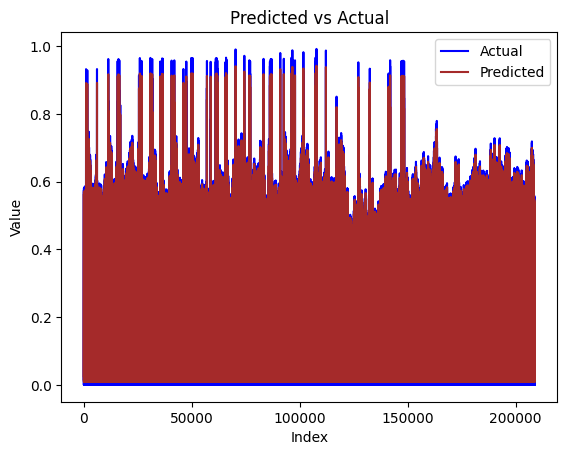

In [130]:
plt.plot(y_test_flat, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(predictions2, label='Predicted',color ='brown' )

# Adding labels and title to the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

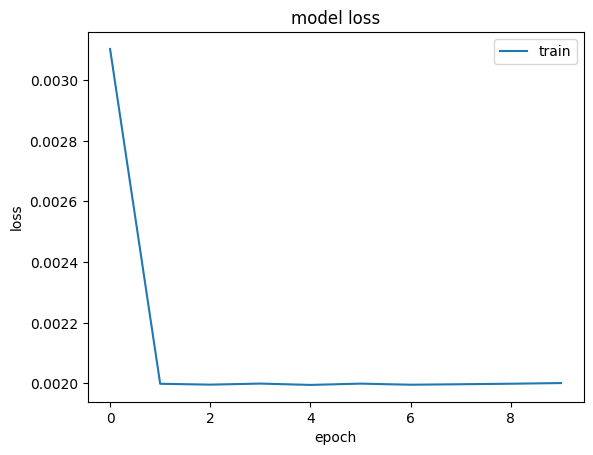

In [134]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()